In [38]:
# @name: my_practice_correlated_mode
# @description: Notebook to experiment with DataSynthesizer package - correlated mode
# @author: Núria Queralt Rosinach
# @date: 08-09-2020
# @version: v1

# DataSynthesizer Practice: correlated mode

To generate a synthetic dataset that preserves some data structure similarity with the real data and data privacy by implementing a differentially private mechanism. 

* It preserves per-attribute probability distributions, i.e. histogram frequencies (Comparison by histrograms)
* It preserves pair-wise attribute correlations, i.e. a bayesian network models correlations between attributes (Comparison by heatmaps)

### 1. Import

In [39]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

import pandas as pd
import os

### 2. User-defined parameters

In [40]:
# input dataset
input_data = './data/adult_ssn.csv'

# location of two output files
mode = 'correlated_attribute_mode'
description_file = f'./out/{mode}/description.json'
synthetic_data = f'./out/{mode}/synthetic_data.csv'

# create output dir
outdir = os.getcwd() + f'/out/{mode}'
if not os.path.isdir(outdir): os.makedirs(outdir)

Default values set here, change here if needed.

In [41]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 20

# specify categorical attributes
categorical_attributes = {'education': True}

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'ssn': True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 1000 # Here 32561 is the same as input dataset, but it can be set to another number.

### 3. DataDescriber

1. Instantiate a DataDescriber
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine

In [42]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT marital-status
Adding attribute relationship
Adding attribute age
Adding attribute sex
Adding attribute income
Adding attribute education
========================== BN constructed ==========================


In [43]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    relationship has parents ['marital-status'].
    age          has parents ['relationship', 'marital-status'].
    sex          has parents ['relationship', 'marital-status'].
    income       has parents ['sex', 'marital-status'].
    education    has parents ['age', 'marital-status'].


### 4. Generate synthetic dataset
1. Instantiate a DataGenerator
2. Generate a synthetic dataset
3. Save it to local machine

In [44]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

### 5. Compare the statistics of input and synthetic data (optional)
The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

#### 5.1 Instantiate a ModelInspector
It needs input dataset, synthetic dataset, and attribute description.


In [45]:
# Read both datasets using pandas
input_df = pd.read_csv(input_data, skipinitialspace = True)
synthetic_df = pd.read_csv(synthetic_data)

print('descriptions of data: {}, s-data: {} shapes'.format(input_df.shape, synthetic_df.shape))

# Read attribute description from the dataset description file
attribute_description = read_json_file(description_file)['attribute_description']

print('description of attribute keys: {}'.format(len(attribute_description)))

descriptions of data: (32561, 7), s-data: (1000, 7) shapes
description of attribute keys: 7


In [46]:
# Describe dataframes for: 
## input_data
print('data:\ncolumns: {}\n{}'.format(input_df.columns,input_df.head(2)))

## synthetic_data
print('\ns-data:\ncolumns: {}\n{}'.format(synthetic_df.columns,synthetic_df.head(2)))

## attribute_description dict
print('\nattributes: {}\nlen: {}'.format(attribute_description.keys(),len(attribute_description.get('ssn'))))
for k, v in attribute_description.items():
    print('key: {} value: {}'.format(k,v))

data:
columns: Index(['ssn', 'age', 'education', 'marital-status', 'relationship', 'sex',
       'income'],
      dtype='object')
           ssn   age  education marital-status relationship   sex income
0  980-24-0087  39.0  Bachelors  Never-married          NaN  Male  <=50K
1  852-90-4418  50.0  Bachelors            NaN      Husband   NaN    NaN

s-data:
columns: Index(['ssn', 'age', 'education', 'marital-status', 'relationship', 'sex',
       'income'],
      dtype='object')
           ssn   age education marital-status   relationship  sex income
0  723-72-3723  31.0   HS-grad  Never-married  Not-in-family  NaN    NaN
1  940-94-0940  31.0       NaN  Never-married  Not-in-family  NaN   >50K

attributes: dict_keys(['ssn', 'age', 'education', 'marital-status', 'relationship', 'sex', 'income'])
len: 9
key: ssn value: {'name': 'ssn', 'data_type': 'SocialSecurityNumber', 'is_categorical': False, 'is_candidate_key': True, 'min': 123456789, 'max': 999999999, 'missing_rate': 0.0, 'distributio

In [47]:
# instantiate a ModelInspector
inspector = ModelInspector(input_df, synthetic_df, attribute_description)

#### 5.2 Compare histograms between input and synthetic datasets

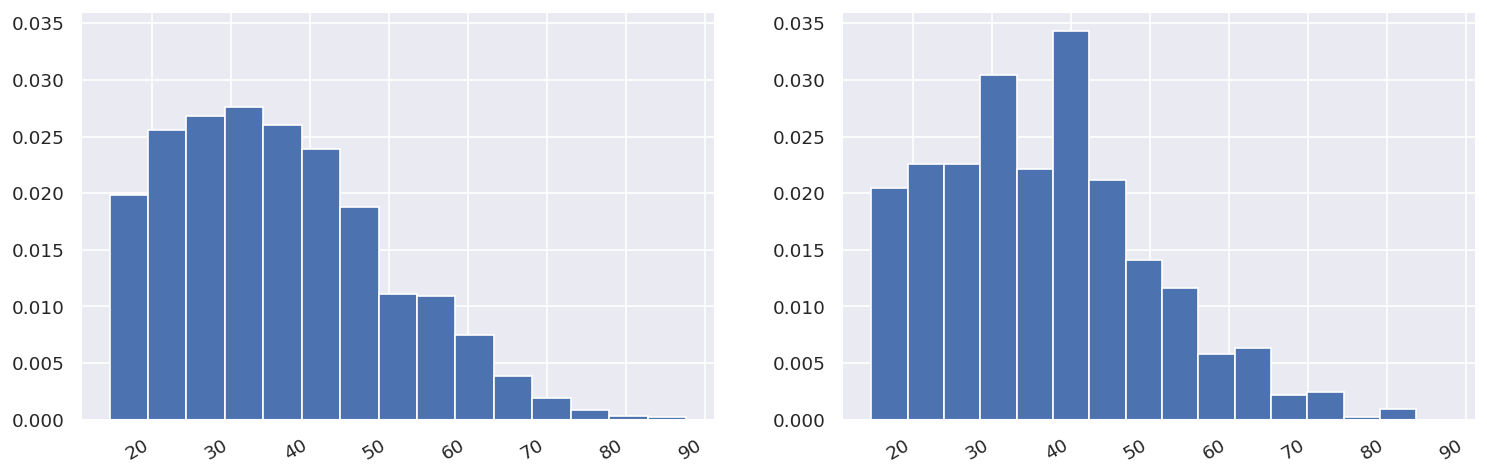

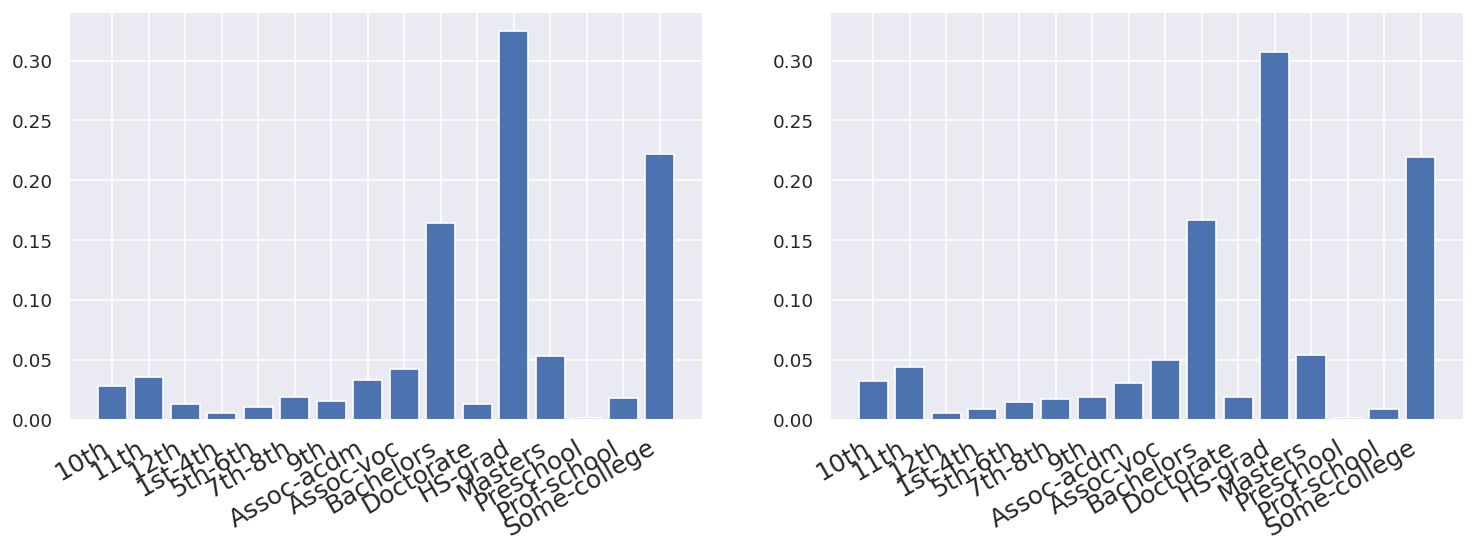

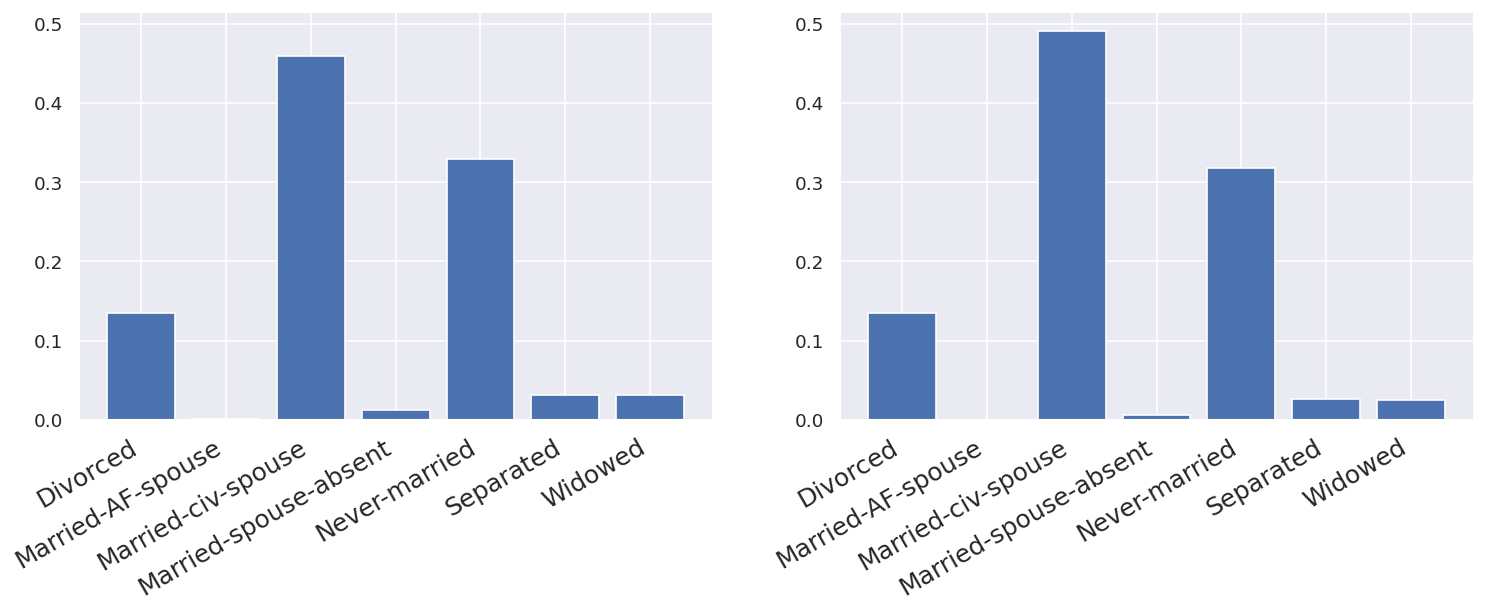

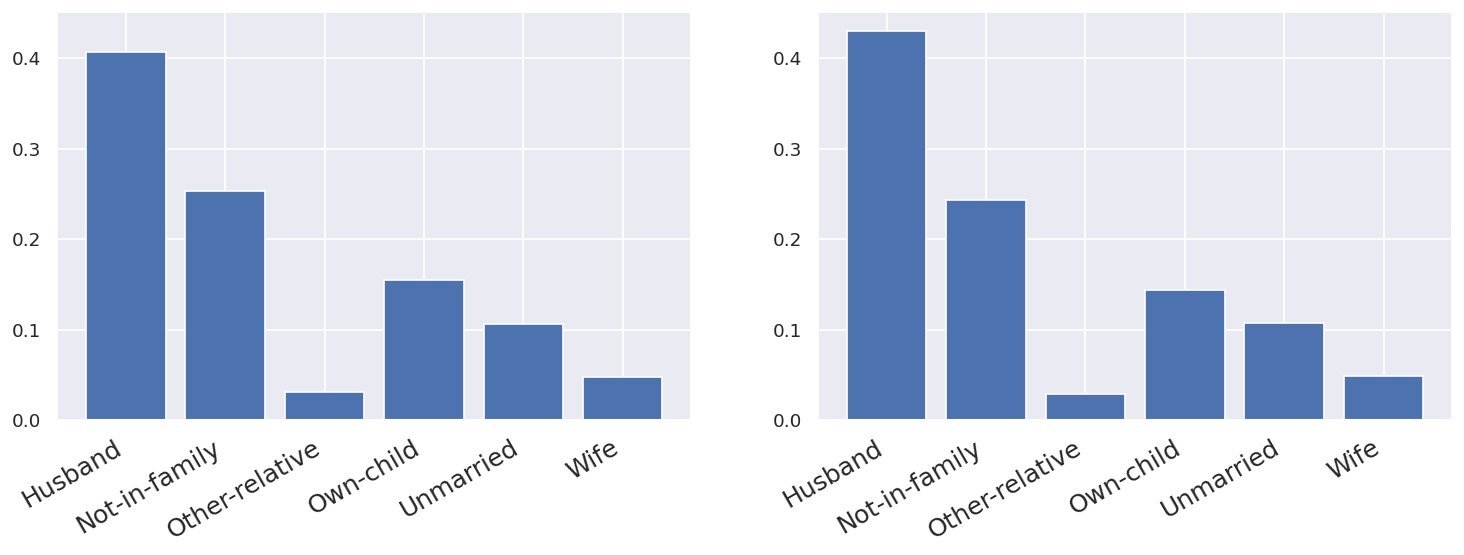

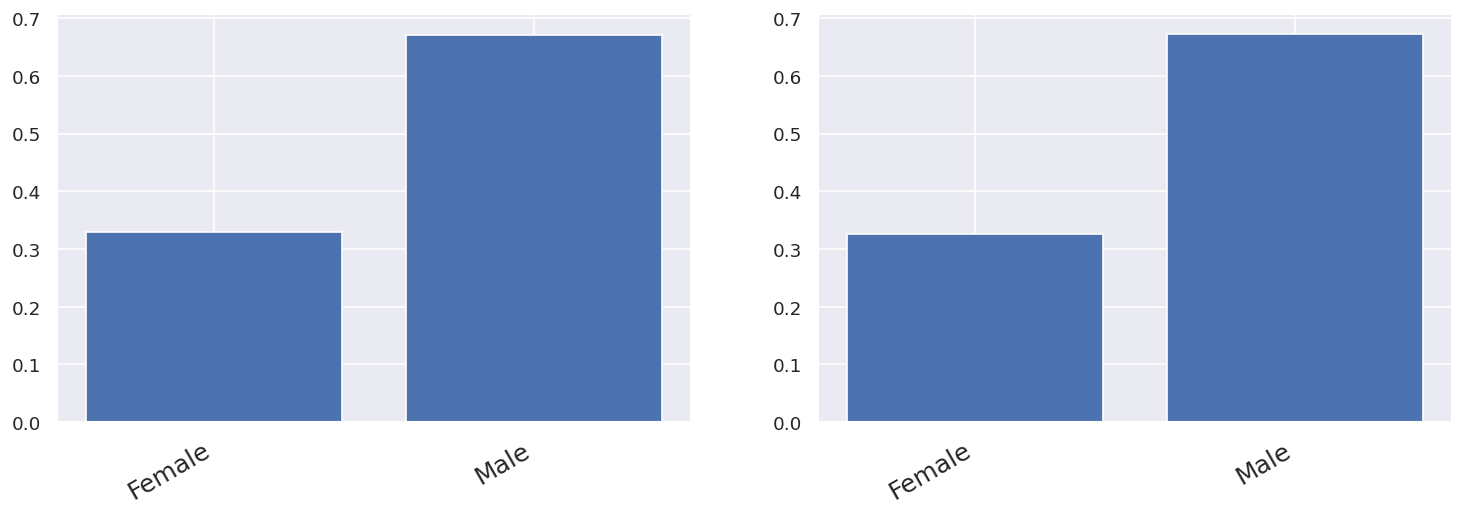

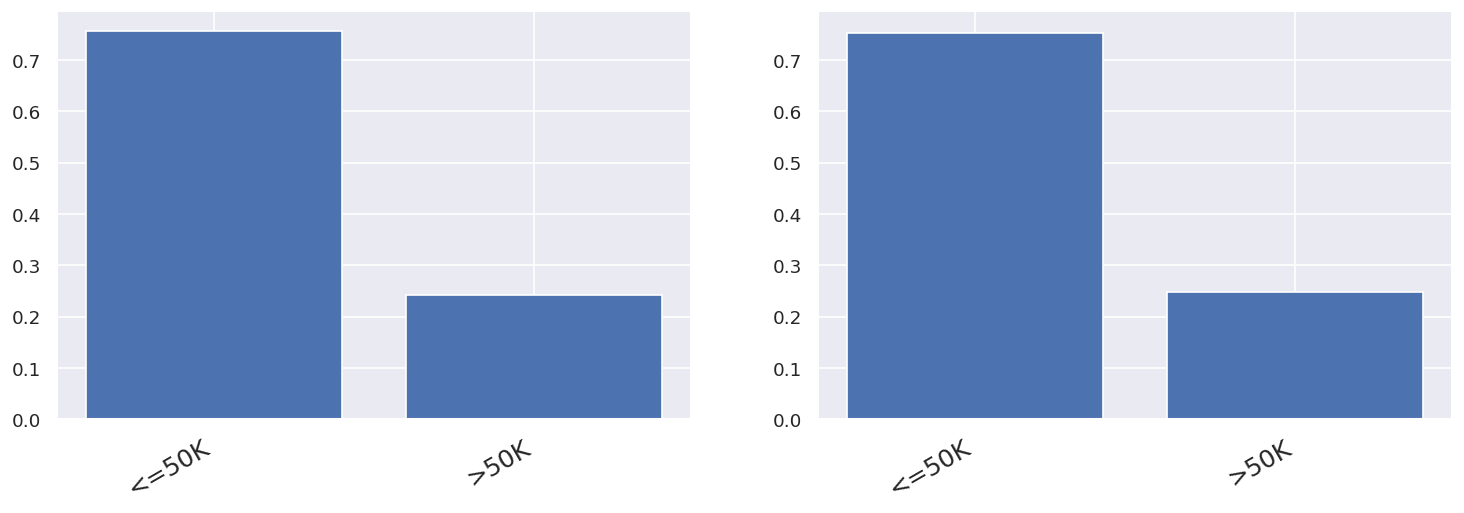

In [48]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

* Probability distributions are kept due to each attribute in each row is sampled independently according to the learned per-attribute distributions (similar histograms).
* One can easily sees here that the correlated mode keeps similarity with real data.

#### 5.3 Compare pairwise mutual information

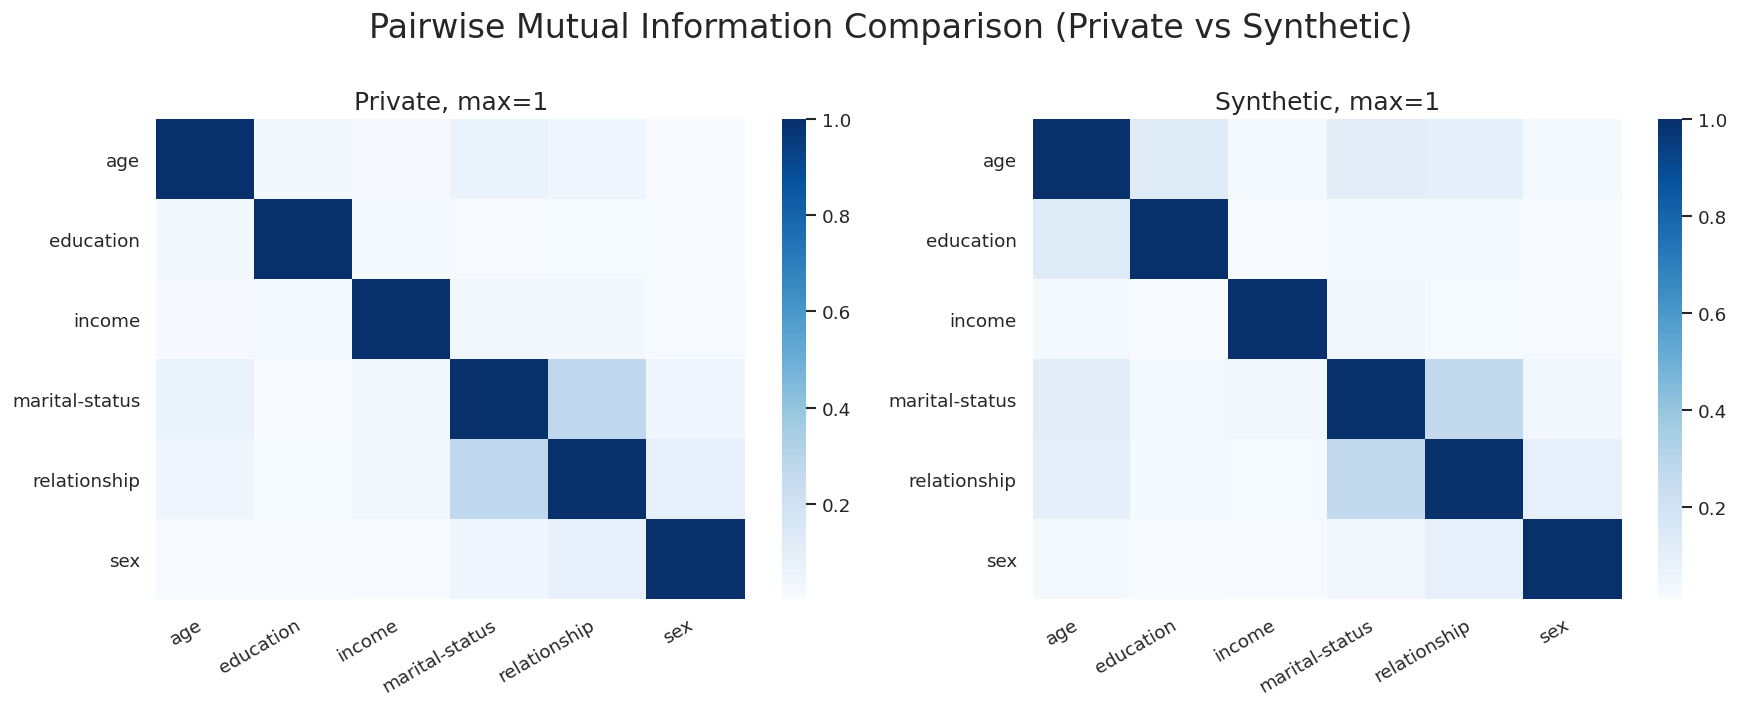

In [49]:
inspector.mutual_information_heatmap()

In probability theory and information theory, the mutual information (MI) of two random variables is a measure of the mutual dependence between the two variables. More specifically, it quantifies the "amount of information" (in units such as shannons, commonly called bits) obtained about one random variable through observing the other random variable.

https://en.wikipedia.org/wiki/Mutual_information

Correlations between attributes are preserved (similar heatmaps): **dependent attributes**